In [2]:
import numpy as np
import pandas as pd
import re
import nltk
#import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#import contractions

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df_combined = pd.read_csv('/content/augment_ai_df2.csv')

df_combined.head(2)

,main_category,text,emotion_intensity
0,happiness,going life together,0.5
1,happiness,feel think always glad something one feeling sad,0.5


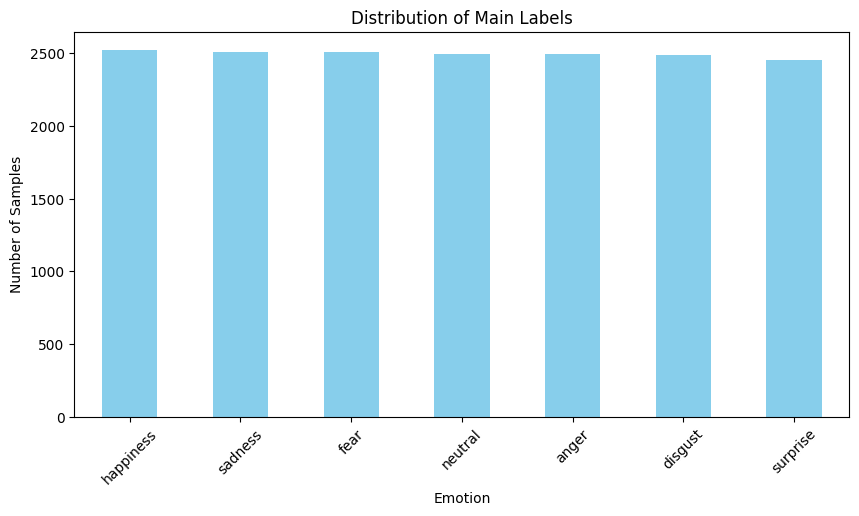

In [4]:
# Count the occurrences of each main_label category
label_counts = df_combined['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [5]:
text_counts = df_combined['text'].value_counts()
print(text_counts.head(20))

text
go post. elbow room.                                                                                   1
going life together                                                                                    1
feel think always glad something one feeling sad                                                       1
feel echoes divine close                                                                               1
feeling quite jolly though                                                                             1
think feel way often teachers respected allowed autonomy                                               1
wow , beautiful here ? yeah , nice , it ?                                                              1
hope get butterflies feeling one day really fantastic                                                  1
want leave thanked parents trusting spend night made feel like respected                               1
palpate impatience rate loss impressed fourth dime

In [6]:
import spacy

nlp = spacy.load("en_core_web_sm")
POS_TAGS = ["NOUN", "VERB", "ADJ", "ADV", "PRON", "PROPN", "NUM", "INTJ"]
def get_pos_vector(text):
    doc = nlp(text)
    counts = {tag: 0 for tag in POS_TAGS}
    for token in doc:
        if token.pos_ in POS_TAGS:
            counts[token.pos_] += 1
    return [counts[tag] for tag in POS_TAGS]

pos_features = np.array([get_pos_vector(txt) for txt in df_combined['text']])
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

sentiment_scores = np.array([get_sentiment_score(txt) for txt in df_combined['text']]).reshape(-1, 1)

tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df_combined['text']).toarray()

def get_negation_count(text):
    negations = {"not", "never", "no", "n't"}
    tokens = text.lower().split()
    return sum(1 for t in tokens if t in negations)

negation_counts = np.array([get_negation_count(txt) for txt in df_combined['text']]).reshape(-1, 1)


extra_features = np.hstack([
    pos_features,
    sentiment_scores,

    tfidf_matrix,
    negation_counts
])

print("extra_features shape:", extra_features.shape)

extra_features shape: (17465, 510)


In [7]:
#
df = df_combined.copy()

In [8]:
label_encoder = LabelEncoder()

df['label'] = label_encoder.fit_transform(df['main_category'])
num_classes = df['label'].nunique()
print("Unique Classes:", list(label_encoder.classes_))

texts = df['text'].values
labels = df['label'].values
MAX_LENGTH = 300
OOV_TOKEN = "<OOV>"
tokenizer = Tokenizer(oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab Size:", vocab_size)

padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
y_onehot = to_categorical(labels, num_classes=num_classes)

Unique Classes: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Vocab Size: 13536


In [9]:
X_seq = padded_sequences
X_ext = extra_features

X_seq, X_test_seq, X_ext, X_test_ext, y_train, y_test = train_test_split(
    X_seq, X_ext, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)
X_seq, X_val_seq, X_ext, X_val_ext, y_train, y_val = train_test_split(
    X_seq, X_ext, y_train, test_size=0.1, random_state=42, stratify=y_train
)
print("Train seq shape:", X_seq.shape, "Train ext shape:", X_ext.shape)
print("Val seq shape:", X_val_seq.shape, "Val ext shape:", X_val_ext.shape)
print("Test seq shape:", X_test_seq.shape, "Test ext shape:", X_test_ext.shape)


Train seq shape: (12574, 300) Train ext shape: (12574, 510)
Val seq shape: (1398, 300) Val ext shape: (1398, 510)
Test seq shape: (3493, 300) Test ext shape: (3493, 510)


In [10]:
EMBEDDING_DIM = 300
embedding_index = {}
glove_path = "/content/glove.6B.300d.txt"
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for w, i in word_index.items():
    if w in embedding_index:
        embedding_matrix[i] = embedding_index[w]
nonzero_rows = np.count_nonzero(np.sum(embedding_matrix, axis=1))
print("Non-zero Embeddings:", nonzero_rows, "/", vocab_size)

Non-zero Embeddings: 11194 / 13536


In [11]:
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred, 'float'), axis=0)
    actual_positives = K.sum(K.cast(y_true, 'float'), axis=0)
    precision = tp / (predicted_positives + K.epsilon())
    recall = tp / (actual_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Sequence branch
sequence_input = Input(shape=(MAX_LENGTH,), name="sequence_input")
x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=output)

model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', f1_metric]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)          │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 300, 300)            │       4,060,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300, 128)            │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 300, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,294,279 (16.38 MB)

 Trainable params: 4,293,895 (16.38 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 122s 290ms/step - accuracy: 0.2091 - f1_metric: 0.0448 - loss: 2.0602 - val_accuracy: 0.3512 - val_f1_metric: 0.0825 - val_loss: 1.6541 - learning_rate: 1.0000e-04
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 114s 289ms/step - accuracy: 0.3721 - f1_metric: 0.1470 - loss: 1.6138 - val_accuracy: 0.4628 - val_f1_metric: 0.1960 - val_loss: 1.4654 - learning_rate: 1.0000e-04
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 113s 288ms/step - accuracy: 0.4562 - f1_metric: 0.2016 - loss: 1.4210 - val_accuracy: 0.4764 - val_f1_metric: 0.2201 - val_loss: 1.4505 - learning_rate: 1.0000e-04
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 114s 290ms/step - accuracy: 0.5397 - f1_metric: 0.2831 - loss: 1.2603 - val_accuracy: 0.5050 - val_f1_metric: 0.2590 - val_loss: 1.3719 - learning_rate: 1.0000e-04
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 114s 290ms/step - accuracy: 0.5952 - f1_metric: 0.4057 - loss: 1.1364 - val_accuracy: 0.6102 - val_f1_metric: 0.4117 - val_loss: 1.1190 - learni

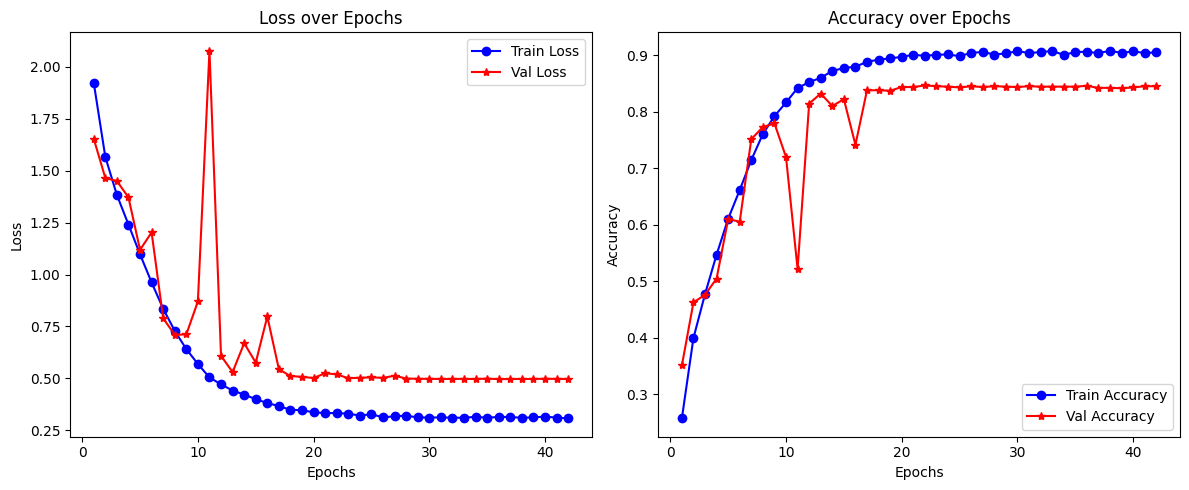

In [13]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, 'b-o', label="Train Loss")
plt.plot(epochs_range, val_loss, 'r-*', label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, 'b-o', label="Train Accuracy")
plt.plot(epochs_range, val_acc, 'r-*', label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
y_test_probs = model.predict(X_test_seq)
y_test_pred = np.argmax(y_test_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.84      0.85       499
     disgust       0.93      0.96      0.94       498
        fear       0.85      0.79      0.82       501
   happiness       0.90      0.84      0.87       504
     neutral       0.74      0.90      0.81       499
     sadness       0.86      0.81      0.84       502
    surprise       0.82      0.81      0.81       490

    accuracy                           0.85      3493
   macro avg       0.85      0.85      0.85      3493
weighted avg       0.85      0.85      0.85      3493



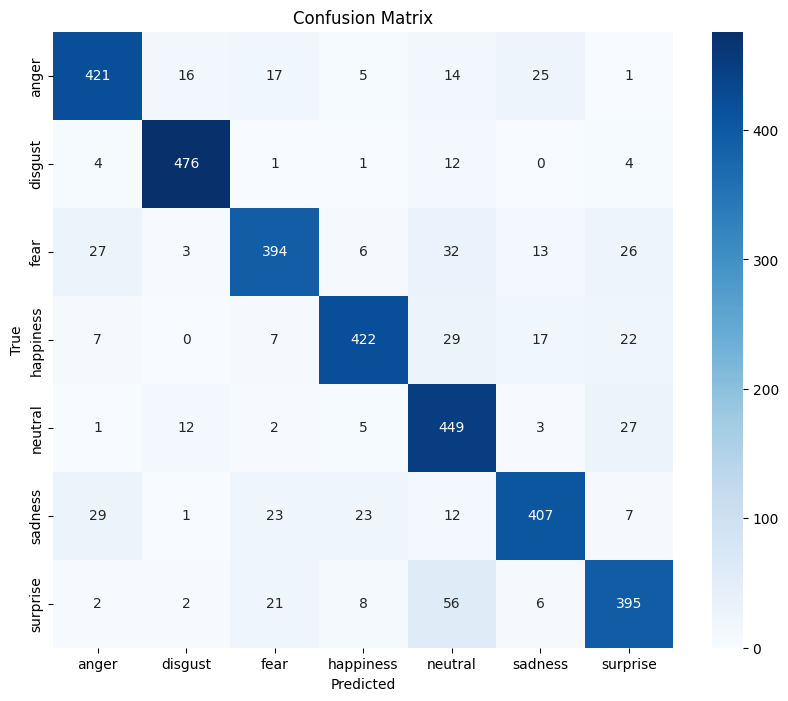

In [15]:
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

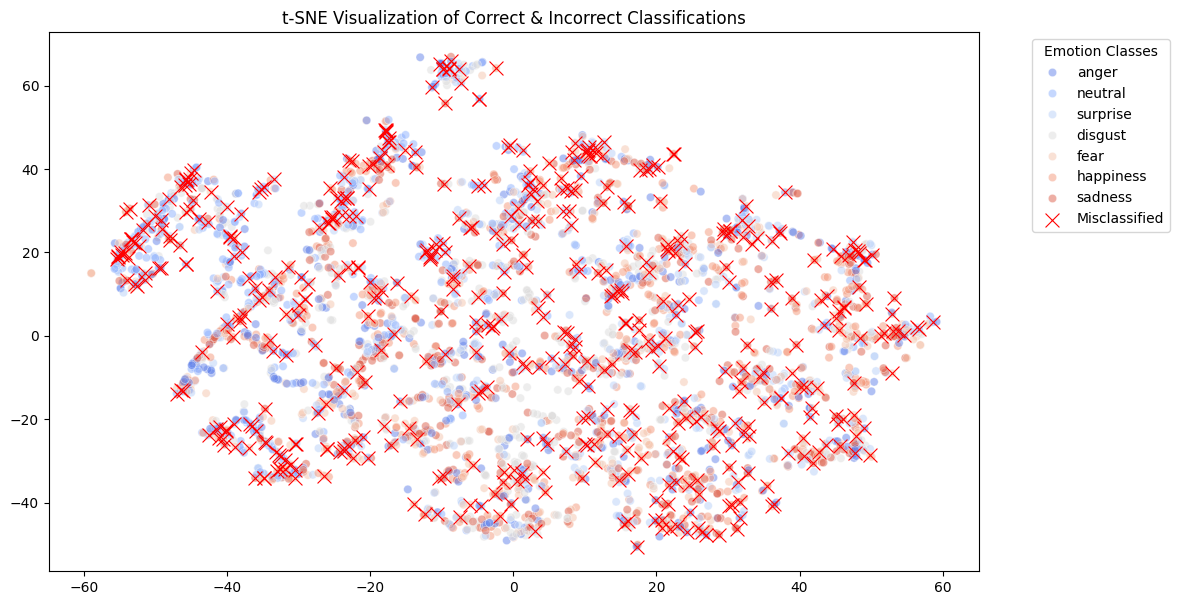

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert embeddings to 2D space using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_test_embedded = tsne.fit_transform(X_test_seq)

# Get true and predicted labels
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(y_test_probs, axis=1)

# Identify misclassified points
incorrect_idxs = np.where(y_test_true != y_test_pred)[0]

# Convert numeric labels to class names
class_labels = label_encoder.classes_  # Extract emotion names
y_test_labels = [class_labels[i] for i in y_test_true]  # True labels as text

plt.figure(figsize=(12, 7))

# Plot correct classifications with actual class names
sns.scatterplot(x=X_test_embedded[:, 0], y=X_test_embedded[:, 1],
                hue=y_test_labels, palette='coolwarm', alpha=0.5, legend=True)

# Overlay misclassified points with red crosses
sns.scatterplot(x=X_test_embedded[incorrect_idxs, 0], y=X_test_embedded[incorrect_idxs, 1],
                color='red', marker="x", s=100, label="Misclassified")

plt.title("t-SNE Visualization of Correct & Incorrect Classifications")
plt.legend(title="Emotion Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Better legend placement
plt.show()


In [17]:
# Extract misclassified examples
misclassified_indices = incorrect_idxs[:100]  # Show first 10 misclassified sentences

print("Misclassified Sentences:")
for i in misclassified_indices:
    true_label = label_encoder.inverse_transform([y_test_true[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_test_pred[i]])[0]

    print(f"Text: {df_combined.iloc[i]['text']}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 100)


Misclassified Sentences:
Text: hope get butterflies feeling one day really fantastic
True Label: fear
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: emotionally engaged feel supporting beliefs values support
True Label: fear
Predicted Label: surprise
----------------------------------------------------------------------------------------------------
Text: also feel nostalgic highschool memories
True Label: happiness
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: like watch people horrible things outraged feel superior
True Label: sadness
Predicted Label: happiness
----------------------------------------------------------------------------------------------------
Text: feel things learn course useful right
True Label: surprise
Predicted Label: happiness
------------------------------------------------------------------

In [18]:
# save model
model.save('model8.h5')

- **Loss Curves:**
  - **Training loss** steadily decreases, showing the model is learning effectively.
  - **Validation loss** fluctuates early, with a spike around epoch 11 — this may suggest overfitting or noisy validation samples.
  - The validation loss stabilises after epoch 20, suggesting decent generalisation.

- **Accuracy Curves:**
  - **Training accuracy** reaches approximately 91%.
  - **Validation accuracy** stabilises around 85%.
  - The small train-validation gap suggests a well-regularised model with minimal overfitting.


 - Classification Report Summary

| Emotion    | Precision | Recall | F1-score | Notes                                        |
|------------|-----------|--------|----------|----------------------------------------------|
| Anger      | 0.86      | 0.84   | 0.85     | Solid performance                            |
| Disgust    | 0.93      | 0.96   | 0.94     | Strongest class performance                  |
| Fear       | 0.85      | 0.79   | 0.82     | Lower recall — often misclassified           |
| Happiness  | 0.90      | 0.84   | 0.87     | Very strong across metrics                   |
| Neutral    | 0.74      | 0.90   | 0.81     | High recall but low precision (over-predicted) |
| Sadness    | 0.86      | 0.81   | 0.84     | Balanced and consistent                      |
| Surprise   | 0.82      | 0.81   | 0.81     | Reasonable performance, room to improve      |

- **Overall Accuracy:** `0.85`
- **Macro Avg F1-score:** `0.85`
- **Weighted Avg F1-score:** `0.85`


- Confusion Matrix Insights

- **Fear** is frequently confused with **neutral, sadness,** and **surprise**.
- **Neutral** is often predicted even when incorrect — consistent with its high recall and low precision.
- **Sadness and happiness** are occasionally mixed, reflecting emotional overlap.
- **Surprise** is often misclassified as **neutral**, which may reflect semantic ambiguity.


- t-SNE Visualisation

- t-SNE shows that some emotion clusters overlap heavily, especially:
  - **Fear vs Neutral**
  - **Sadness vs Happiness**
  - **Surprise vs Neutral**
- **Red crosses** (misclassified points) are dispersed throughout, showing that errors are spread across the dataset and not due to a few specific clusters.


- Qualitative Analysis: Misclassified Sentences

- Many misclassified texts are **short**, **abstract**, or **figurative**, e.g.:
- 
- These cases often lack strong sentiment cues or rely on poetic expressions, making them difficult even for humans to classify consistently.


- Summary

- The model is **effective at detecting strong emotional signals**, particularly for **disgust** and **happiness**.
- **Ambiguous or context-dependent emotions** such as **fear** and **neutral** are more prone to misclassification.
- Model shows good generalisation, with **85% accuracy** on the test set.

**Possible Improvement**

- Add an **attention mechanism** to focus on emotionally relevant tokens.
- Augment training data for underperforming classes like **fear**, **surprise**, and **neutral**.
-  **sentence-level embeddings** or **contextual sentiment analysis** to capture more nuanced emotions.


